# Lending Club Data Credit Risk Analysis - Predizione dei Default



In [102]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import sklearn.model_selection as model_selection
from dataCleaner import dataCleaner
import itertools

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, confusion_matrix, classification_report, plot_confusion_matrix

from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

from scipy.stats import iqr
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SVMSMOTE, RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.neighbors import LocalOutlierFactor


In [2]:
data = pd.read_csv('loan.csv', low_memory=False)

print(data.shape)
data.head()

(39717, 111)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [3]:
data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)

In [4]:
data.loan_status.value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

In [5]:
data = data[(data['loan_status'] == 'Fully Paid') | (data['loan_status'] == 'Charged Off')]

In [6]:
data.loan_status.value_counts()

Fully Paid     32950
Charged Off     5627
Name: loan_status, dtype: int64

In [7]:
data['loan_status'].head

<bound method NDFrame.head of 0         Fully Paid
1        Charged Off
2         Fully Paid
3         Fully Paid
5         Fully Paid
            ...     
39712     Fully Paid
39713     Fully Paid
39714     Fully Paid
39715     Fully Paid
39716     Fully Paid
Name: loan_status, Length: 38577, dtype: object>

Effettuiamo lo split training-test secondo la proporzione 70%-30%

In [8]:
columns = data.columns
features = columns.drop('loan_status')
target = ['loan_status']
x = data[features]
y = data[target]

train_x, raw_test_x, train_y, raw_test_y = model_selection.train_test_split(x, y, test_size=0.3, random_state=0)
dataCleaner = dataCleaner()

In [9]:

## FIX i warning
loan_status_dict = {'Fully Paid':0, 'Charged Off':1}
dataCleaner.set_target_mapDict(loan_status_dict)
dataCleaner.encode_target(train_y)


/home/valerio/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [10]:
train_y['loan_status'].head(10)

29845    0
31699    0
30480    0
35448    0
15977    0
29921    0
7628     0
28132    1
13205    0
34007    0
Name: loan_status, dtype: int64

In [11]:
#train_y.loan_status.astype(float) #TODO in teoria converto a float in dataCleaner.encode_target(train_y), ma non funziona, perché?

In [12]:
len(train_x.columns)

110

In [13]:
def unique_non_null(df):
    return df.dropna().unique()

In [14]:
colNotUniqueValue = []
for col in train_x.columns:
    colUniqueValuesCount = len(unique_non_null(data[col]))
    if colUniqueValuesCount > 1:
        colNotUniqueValue.append(col)
    print(col, "\t", colUniqueValuesCount)                  # DA FORMATTARE MEGLIO

id 	 38577
member_id 	 38577
loan_amnt 	 870
funded_amnt 	 1019
funded_amnt_inv 	 8050
term 	 2
int_rate 	 370
installment 	 15022
grade 	 7
sub_grade 	 35
emp_title 	 28027
emp_length 	 11
home_ownership 	 5
annual_inc 	 5215
verification_status 	 3
issue_d 	 55
pymnt_plan 	 1
url 	 38577
desc 	 25803
purpose 	 14
title 	 19297
zip_code 	 822
addr_state 	 50
dti 	 2853
delinq_2yrs 	 11
earliest_cr_line 	 524
inq_last_6mths 	 9
mths_since_last_delinq 	 95
mths_since_last_record 	 111
open_acc 	 40
pub_rec 	 5
revol_bal 	 21275
revol_util 	 1088
total_acc 	 82
initial_list_status 	 1
out_prncp 	 1
out_prncp_inv 	 1
total_pymnt 	 36714
total_pymnt_inv 	 36387
total_rec_prncp 	 6841
total_rec_int 	 34025
total_rec_late_fee 	 1320
recoveries 	 4040
collection_recovery_fee 	 2616
last_pymnt_d 	 101
last_pymnt_amnt 	 34418
next_pymnt_d 	 0
last_credit_pull_d 	 106
collections_12_mths_ex_med 	 1
mths_since_last_major_derog 	 0
policy_code 	 1
application_type 	 1
annual_inc_joint 	 0
dti_join

In [15]:
train_x = train_x.loc[:, colNotUniqueValue]

In [16]:
len(train_x.columns) 


44

Controlliamo se c'è qualche riga la cui percentuale di NaN supera il 50%

In [17]:
percentageNanInRow = np.ones(len(train_x))*len(train_x.columns)

percentageNanInRow = np.divide((train_x.isna().sum(axis=1)) , percentageNanInRow)
np.max(percentageNanInRow)

0.13636363636363635

Eliminazione delle features non utili alla predizione e separazione delle feature categoriche da quelle numeriche

In [18]:
categorical_features=[]
numerical_features=[]

In [19]:
colIdx = range(0,10)
train_x.iloc[:,colIdx].head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade
29845,511215,660289,9000,9000,9000.000000,36 months,10.25%,291.47,B,B2
31699,492140,629271,25000,25000,22725.000000,36 months,10.25%,809.62,B,B2
30480,507735,654945,5000,5000,5000.000000,36 months,15.33%,174.15,D,D3
35448,435440,520308,9000,9000,8748.151461,36 months,12.87%,302.70,C,C1
15977,739735,937342,5600,5600,5600.000000,60 months,19.36%,146.38,F,F4
29921,516506,667562,1500,1500,1500.000000,36 months,13.85%,51.16,C,C4
7628,879031,1093835,7500,7500,7425.000000,36 months,6.03%,228.27,A,A1
28132,543003,700619,4000,4000,3950.000000,60 months,11.12%,87.21,B,B3
13205,785977,989326,15000,15000,15000.000000,36 months,12.99%,505.34,C,C1
34007,438587,528605,14400,14400,14275.000000,36 months,11.14%,472.38,B,B1


<b>Attributi scartati:</b>

*id* e *member_id*: codici identificativi non utili per la predizione

*funded_amnt* e *funded_amnt_inv*: attributi che non sono disponibili al momento della scelta se effettuare il prestito o no

*grade* e *sub_grade*: attributi in stretta dipendenza con la feature *int_rate*


In [20]:
categorical_features.append('term')
numerical_features.append('loan_amnt')
numerical_features.append('installment')
numerical_features.append('int_rate')

In [21]:
colIdx = range(10,20)
train_x.iloc[:,colIdx].head(10)

,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,url,desc,purpose,title
29845,Loomis Group,3 years,RENT,55000.0,Not Verified,May-10,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Credit Cards
31699,Internal Revenue Service,10+ years,RENT,82000.0,Not Verified,Mar-10,https://lendingclub.com/browse/loanDetail.acti...,NaN,other,"50 down, 50 to go"
30480,Yahoo Inc.,3 years,RENT,94000.0,Not Verified,Apr-10,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 04/23/10 > The express pur...,debt_consolidation,Smartly Consolidating Debts for Lower Interest...
35448,Department of Energy,< 1 year,RENT,67092.0,Not Verified,Aug-09,https://lendingclub.com/browse/loanDetail.acti...,To Whom It May Concern: I have reached a stag...,major_purchase,Major Purchase
15977,Dootlitle's Woodfire,3 years,RENT,49008.0,Source Verified,May-11,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 04/27/11 > I am a chiropra...,major_purchase,Equinox
29921,Eglin Federal Credit Union,2 years,RENT,24000.0,Not Verified,May-10,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 05/12/10 > Loan Needed to ...,other,EDUCATION TROY 2010
7628,"Riverstone Enterprise Solutions, LLC",< 1 year,MORTGAGE,138000.0,Source Verified,Sep-11,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,Bathroom Remodel
28132,Costco,1 year,MORTGAGE,24000.0,Source Verified,Jul-10,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,baby payoff loan
13205,Parish Anesthesia Consultants,5 years,MORTGAGE,370000.0,Verified,Jun-11,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 06/14/11 > This Loan is fo...,home_improvement,pool loan
34007,Mayer Brown LLP,2 years,OWN,115000.0,Not Verified,Nov-09,https://lendingclub.com/browse/loanDetail.acti...,528605 added on 11/09/09 > I am a responsibl...,debt_consolidation,Consolidation Loan


<b>Attributi scartati:</b>

*emp_title* e *issue_d*: attributi non utili per la predizione

*loan_status*: attributo sul quale di vuole effettuare la predizione

*url* e *desc*: attributi non utili per la predizione


In [22]:
categorical_features.append('home_ownership')
categorical_features.append('purpose')
categorical_features.append('verification_status')
numerical_features.append('emp_length')
numerical_features.append('annual_inc')

In [23]:
colIdx = range(20,30)
train_x.iloc[:,colIdx].head(10)

,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec
29845,941xx,CA,9.25,0,Dec-03,0,NaN,NaN,4,0
31699,018xx,MA,2.49,0,Jul-95,0,NaN,NaN,6,0
30480,920xx,CA,3.83,0,Jun-94,0,29.0,NaN,2,0
35448,208xx,MD,15.85,0,Nov-00,3,NaN,NaN,9,0
15977,551xx,MN,17.87,0,Jun-98,1,43.0,NaN,15,0
29921,325xx,FL,4.65,0,Oct-06,0,NaN,NaN,6,0
7628,210xx,MD,4.42,0,Aug-01,0,NaN,NaN,11,0
28132,871xx,NM,1.63,0,Apr-02,1,NaN,NaN,6,0
13205,707xx,LA,5.64,0,Oct-93,0,67.0,NaN,13,0
34007,606xx,IL,11.30,0,Feb-99,0,NaN,NaN,18,0


<b>Attributi scartati:</b>

*title*, *zip_code*, *addr_state*: attributi che risultano non essere correlati con la predizione

*mths_since_last_delinq* e *mths_since_last_record*: attributi che non sono disponibili al momento della scelta se effettuare il prestito o no

In [24]:
numerical_features.append('delinq_2yrs')
numerical_features.append('earliest_cr_line')
numerical_features.append('open_acc')
numerical_features.append('inq_last_6mths')
numerical_features.append('dti')

In [25]:
colIdx = range(30,len(train_x.columns))
train_x.iloc[:,colIdx].head(10)

,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
29845,17031,58%,6,10493.412270,10493.41,9000.00,1493.41,0.00,0.0,0.0,May-13,350.83,May-13,0.0
31699,8185,8.30%,15,28326.220880,25748.54,25000.00,3326.22,0.00,0.0,0.0,Jan-12,3293.61,Jan-12,0.0
30480,4820,96.40%,14,6294.875422,6294.88,5000.00,1264.88,30.00,0.0,0.0,Mar-13,518.26,Dec-14,0.0
35448,22002,81.20%,18,10927.866280,10607.25,9000.00,1897.61,30.26,0.0,0.0,Sep-12,310.78,Oct-12,0.0
15977,5103,64.60%,25,7377.181049,7377.18,5600.00,1777.18,0.00,0.0,0.0,Oct-14,32.94,May-16,0.0
29921,3296,54.90%,8,1517.400000,1517.40,1500.00,17.40,0.00,0.0,0.0,Jul-10,1517.73,Mar-16,0.0
7628,3738,9.30%,19,8130.366066,8049.06,7500.00,630.37,0.00,0.0,0.0,Sep-13,2882.88,Oct-13,0.0
28132,3492,9.30%,11,2694.210000,2660.42,1785.03,909.18,0.00,0.0,0.0,Feb-13,87.21,May-16,0.0
13205,8078,68.50%,44,18192.110280,18192.11,15000.00,3192.11,0.00,0.0,0.0,Jul-14,526.33,Jul-14,0.0
34007,28541,41.30%,54,16815.431020,16669.46,14400.00,2415.43,0.00,0.0,0.0,Feb-12,4536.26,Dec-15,0.0


<b>Attributi scartati:</b>

*total_acc*, *total_pymnt* e *total_pymnt_inv*,

*total_rec_prncp*, *total_rec_int*, *total_rec_late_fee*: attributi che non sono disponibili al momento della scelta se effettuare il prestito o no

*recoveries* e *collection_recovery_fee*: attributi non utili per la predizione

*last_pymnt_d* e *last_pymnt_amnt*: attributi che non sono disponibili al momento della scelta se effettuare il prestito o no


In [26]:
numerical_features.append('pub_rec')
numerical_features.append('revol_util')
numerical_features.append('revol_bal')
numerical_features.append('last_credit_pull_d')
numerical_features.append('pub_rec_bankruptcies')

In [27]:
categorical_features

['term', 'home_ownership', 'purpose', 'verification_status']

In [28]:
numerical_features

['loan_amnt',
 'installment',
 'int_rate',
 'emp_length',
 'annual_inc',
 'delinq_2yrs',
 'earliest_cr_line',
 'open_acc',
 'inq_last_6mths',
 'dti',
 'pub_rec',
 'revol_util',
 'revol_bal',
 'last_credit_pull_d',
 'pub_rec_bankruptcies']

In [29]:
train_x_categorical=pd.DataFrame()
for col in categorical_features:
    train_x_categorical=pd.concat([ train_x_categorical, train_x[col]], axis= 1)
    dataCleaner.addFeatureToBeMantained(col)

train_x_categorical.head()

,term,home_ownership,purpose,verification_status
29845,36 months,RENT,debt_consolidation,Not Verified
31699,36 months,RENT,other,Not Verified
30480,36 months,RENT,debt_consolidation,Not Verified
35448,36 months,RENT,major_purchase,Not Verified
15977,60 months,RENT,major_purchase,Source Verified


In [30]:
train_x_numerical=pd.DataFrame()
for col in numerical_features:
    train_x_numerical=pd.concat([ train_x_numerical, train_x[col]], axis= 1)
    dataCleaner.addFeatureToBeMantained(col)

train_x_numerical.head()


,loan_amnt,installment,int_rate,emp_length,annual_inc,delinq_2yrs,earliest_cr_line,open_acc,inq_last_6mths,dti,pub_rec,revol_util,revol_bal,last_credit_pull_d,pub_rec_bankruptcies
29845,9000,291.47,10.25%,3 years,55000.0,0,Dec-03,4,0,9.25,0,58%,17031,May-13,0.0
31699,25000,809.62,10.25%,10+ years,82000.0,0,Jul-95,6,0,2.49,0,8.30%,8185,Jan-12,0.0
30480,5000,174.15,15.33%,3 years,94000.0,0,Jun-94,2,0,3.83,0,96.40%,4820,Dec-14,0.0
35448,9000,302.70,12.87%,< 1 year,67092.0,0,Nov-00,9,3,15.85,0,81.20%,22002,Oct-12,0.0
15977,5600,146.38,19.36%,3 years,49008.0,0,Jun-98,15,1,17.87,0,64.60%,5103,May-16,0.0


## Parsing delle colonne

### Feature Numeriche

In [31]:
#Rimozione del segno di percentuale dalle colonne 'revol_util' e 'int_rate'
#-----------------------------------------------------------------------------------------------------------------------------
featureList = ['revol_util', 'int_rate']
dataCleaner.removePercentageSign(train_x_numerical, featureList)

In [32]:
#Conversione delle date in numeri in quanto se gestite come variabili categoriche avrebbero generato troppe dummy variables
#------------------------------------------------------------------------------------------------------------------------------
featureList = ['last_credit_pull_d', 'earliest_cr_line']
dataCleaner.convertFromDateToInt(train_x_numerical, "%b-%y", featureList)

/home/valerio/magistrale/ml/MachineLearningProject/dataCleaner.py:42: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  data[feature] = pd.DatetimeIndex(data[feature]).astype(np.int64)*1e-9


In [33]:
#Conversione di 'emp_length' in una variabile numerica ordinale
#-------------------------------------------------------------------------------------------------------------------------------
train_x_numerical.emp_length.unique()

array(['3 years', '10+ years', '< 1 year', '2 years', '1 year', '5 years',
       nan, '4 years', '6 years', '7 years', '8 years', '9 years'],
      dtype=object)

In [34]:
mapDict = {
    'emp_length': {
        '10+ years': 10,
        '9 years': 9,
        '8 years': 8,
        '7 years': 7,
        '6 years': 6,
        '5 years': 5,
        '4 years': 4,
        '3 years': 3,
        '2 years': 2,
        '1 year': 1,
        '< 1 year': 0,
    }
}

dataCleaner.set_emp_length_mapDict(mapDict)
dataCleaner.encode_emp_length(train_x_numerical)

In [35]:
train_x_numerical.head()

,loan_amnt,installment,int_rate,emp_length,annual_inc,delinq_2yrs,earliest_cr_line,open_acc,inq_last_6mths,dti,pub_rec,revol_util,revol_bal,last_credit_pull_d,pub_rec_bankruptcies
29845,9000,291.47,10.25,3.0,55000.0,0,1.070237e+09,4,0,9.25,0,58.0,17031,1.367366e+09,0.0
31699,25000,809.62,10.25,10.0,82000.0,0,8.045568e+08,6,0,2.49,0,8.3,8185,1.325376e+09,0.0
30480,5000,174.15,15.33,3.0,94000.0,0,7.704288e+08,2,0,3.83,0,96.4,4820,1.417392e+09,0.0
35448,9000,302.70,12.87,0.0,67092.0,0,9.730368e+08,9,3,15.85,0,81.2,22002,1.349050e+09,0.0
15977,5600,146.38,19.36,3.0,49008.0,0,8.966592e+08,15,1,17.87,0,64.6,5103,1.462061e+09,0.0


In [36]:
train_x_numerical.isna().sum()

loan_amnt                 0
installment               0
int_rate                  0
emp_length              692
annual_inc                0
delinq_2yrs               0
earliest_cr_line          0
open_acc                  0
inq_last_6mths            0
dti                       0
pub_rec                   0
revol_util               39
revol_bal                 0
last_credit_pull_d        0
pub_rec_bankruptcies    492
dtype: int64

In [37]:
#Conversione delle variabili numeriche in float
#-------------------------------------------------------------------------------------------------------------------------------
dataCleaner.convertToFloat(train_x_numerical)

### Features Categoriche

In [38]:
for col in train_x_categorical.columns:
    print(col,'\n',train_x_categorical[col].unique(),'\n')

term 
 [' 36 months' ' 60 months'] 

home_ownership 
 ['RENT' 'MORTGAGE' 'OWN' 'OTHER' 'NONE'] 

purpose 
 ['debt_consolidation' 'other' 'major_purchase' 'home_improvement'
 'credit_card' 'house' 'car' 'medical' 'small_business' 'educational'
 'wedding' 'moving' 'vacation' 'renewable_energy'] 

verification_status 
 ['Not Verified' 'Source Verified' 'Verified'] 



In [39]:
#Creazione delle dummy variables tramite codifica One-Hot
#------------------------------------------------------------------------------------------------------------------------------
for col in train_x_categorical.columns:
    dataCleaner.addFeatureToBeOneHotEncoded(col)
   
encoder = OneHotEncoder(drop='first') # rimuovo una variabile dummy per ogni feature categorica in modo da non avere collinearità
encoder.fit(train_x_categorical)
dataCleaner.setOneHotEncoder(encoder)
train_x_categorical = dataCleaner.applyOneHotEncoding(train_x_categorical)

In [40]:
train_x_categorical.head()

,x0_ 60 months,x1_NONE,x1_OTHER,x1_OWN,x1_RENT,x2_credit_card,x2_debt_consolidation,x2_educational,x2_home_improvement,x2_house,x2_major_purchase,x2_medical,x2_moving,x2_other,x2_renewable_energy,x2_small_business,x2_vacation,x2_wedding,x3_Source Verified,x3_Verified
29845,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31699,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
30480,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35448,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15977,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Outlier Detection and Removal

Il rilevamento degli outlier (outlier detection) consiste nell'identificazione degli elementi di un dataset che differiscono in modo significativo dagli altri elementi del dataset.

Le tecniche di rilevamento degli outliers possono essere suddivise in approcci univariati o approcci multivariati.

Gli approcci univariati consistono nel considerare una singola feature ed andare ad inviduare quali elementi del dataset presentano un valore anomalo per quella feature.

Gli approcci multivariati, invece, considerano contemporaneamente più features e cercano di scovare combinazioni anomale nei valori delle features.

Vediamo un esempio:
<table cellspacing="5", style="background-color: white; color: black" >
      <tbody>
        <tr>
          <td>Nome</td>
          <td>Età</td>
          <td>Altezza (cm)</td>
          <td>Peso (kg)</td>
          <td>Figli</td>
        </tr>
        <tr>
          <td>Maria</td>
          <td style="background-color: #9fc5e8;">10</td>
          <td>134</td>
          <td>42</td>
          <td style="background-color: #9fc5e8;">2<br>
          </td>
        </tr>
        <tr>
          <td>Lucia</td>
          <td>18</td>
          <td>174<br>
          </td>
          <td>60<br>
          </td>
          <td>1<br>
          </td>
        </tr>
        <tr>
          <td>Anna</td>
          <td>16</td>
          <td>164<br>
          </td>
          <td>53<br>
          </td>
          <td>0<br>
          </td>
        </tr>
        <tr>
          <td style="width: 50px;">Paola</td>
          <td style="width: 50px;">20</td>
          <td style="width: 50px; background-color: #f1c232;">270<br>
          </td>
          <td style="width: 50px;">61<br>
          </td>
          <td style="width: 50px;">2<br>
          </td>
        </tr>
        <tr>
          <td>Sofia</td>
          <td>9</td>
          <td>110</td>
          <td>38</td>
          <td>0</td>
        </tr>
        <tr>
          <td>Mara</td>
          <td>8</td>
          <td>102</td>
          <td>34</td>
          <td>0</td>
        </tr>
        <tr>
          <td>Asia</td>
          <td>9</td>
          <td>114</td>
          <td>36</td>
          <td>0</td>
        </tr>
      </tbody>
    </table>

Nel primo caso, in arancione, vediamo che il valore 270 per l'altezza di una persona non è plausibile, dunque possiamo etichettare questo valore come outlier. Si noti che per farlo abbiamo considerato solo l'attributo "Altezza".

Nel secondo caso, in azzurro, nessun valore per gli attributi della prima istanza del dataset sono di per sé allarmanti: in particolare il valore 10 per l'età è perfettamente plausibile, così come lo è il valore 2 in riferimento al numero di figli, tuttavia ciò che è anomalo è che contemporaneamente l'età sia 10 e il numero di figli sia diverso da 0! In questo caso la prima istanza del dataset rappresenta un outlier.


### Outlier Detection Univariata: IQR Rule

L'approccio univariato all'outlier detection è fatto tramite la interquartile range rule (IQR Rule).

Per definizione, il 25% dei valori assunti da una campione di cadono al di sotto di Q1 e il 25% cadono al di sopra di Q3. Definiamo questo intervallo come interquartile range $$IQR = Q3 - Q1$$
L'interquartile range rule consiste nel classificare come outliers quei valori che cadono al di fuori di un certo intervallo di decisione definito a partire dall'interquantile range: $$[Q1 - 1.5*IQR, Q3 + 1.5*IQR]$$

La ragione del valore 1.5 si trova con riferimento alla normale standard.

<img src="Immagini\IQR Rule.png" width="400"/>

Per una normale standard pochi valori, $\simeq0.28\%$. è più lontano dalla media di $3\sigma$, dunque vorremmo replicare questa caratteristica scegliendo un opportuno intervallo di decisione.

Come si vede dalla figura precedente Q1 e Q3 corrispondono a circa $\pm0.675\sigma$, dunque l'intervallo $[ Q1 - 1.5 \cdot IQR, Q3 + 1.5 \cdot IQR ]$ diventa:

$$
\begin{aligned}
& [-0.675\sigma - 1.5*(0.675\sigma-(-0.675\sigma)), 0.675\sigma + 1.5*(0.675\sigma-(-0.675\sigma))] =\\
& [-0.675\sigma - 2.025\sigma, 0.675\sigma + 2.025\sigma] =\\
& [ - 2.7\sigma, + 2.7\sigma]\\
\end{aligned}
$$


In [41]:
counter = 0
for col in train_x_numerical.columns:
    iqr_value = iqr(train_x_numerical[col])
    q1 = np.quantile(train_x_numerical[col], 0.25)
    q3 = np.quantile(train_x_numerical[col], 0.75)
    for i in range(0, train_x_numerical.shape[0]):
        if train_x_numerical[col].iloc[i] > (q3+1.5*(iqr_value)) or train_x_numerical[col].iloc[i] < (q1 - 1.5*(iqr_value)):
            counter = counter + 1
    print(col, counter, counter/train_x_numerical[col].shape[0])  #TODO FORMATTARE MEGLIO
    counter = 0


loan_amnt 751 0.027811724623190016
installment 968 0.03584786875532348
int_rate 59 0.0021849424138058733
emp_length 0 0.0
annual_inc 1226 0.04540236270044069
delinq_2yrs 2909 0.10772877087730993
earliest_cr_line 981 0.03632929674480613
open_acc 349 0.01292448987149576
inq_last_6mths 2503 0.09269340443654409
dti 0 0.0
pub_rec 1454 0.053845868977521014
revol_util 0 0.0
revol_bal 1689 0.06254860571047662
last_credit_pull_d 44 0.001629448579787431
pub_rec_bankruptcies 0 0.0


Dalla valutazione della quantità di valori che verrebbero considerati outliers tramite la IQR Rule, possiamo constatare che per i dati in nostro possesso questo metodo non risulta essere molto buono per rilevare gli outliers.
Notiamo, infatti, che per diverse features, la percentuale di valori considerati outliers dalla IQR Rule è troppo alta rispetto, per una normale standard il valore è $\pm 0.28\%$, mentre noi ci troviamo features con valori al di sopra del $10\%$.

La ragione di ciò risiede nel fatto che la regola IQR assume che i dati siano distribuiti approssimativamente come una gaussiana. Ora, seppur il metodo è robusto e nella pratica ci accorgiamo che funziona bene anche con distribuzioni leggermente diverse dalla gaussiana, nel nostro caso le distribuzioni sono troppo diverse.

Verifichiamo graficamente la precedente affermazione, andando a graficare i QQ-Plots di ciascuna feature: i dati di un campione sono distribuiti secondo una gaussiana se i punti del QQ-Plot si distribuiscono sulla bisettrice del primo-terzo quadrante.  

/home/valerio/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/valerio/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/valerio/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/valerio/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'mark

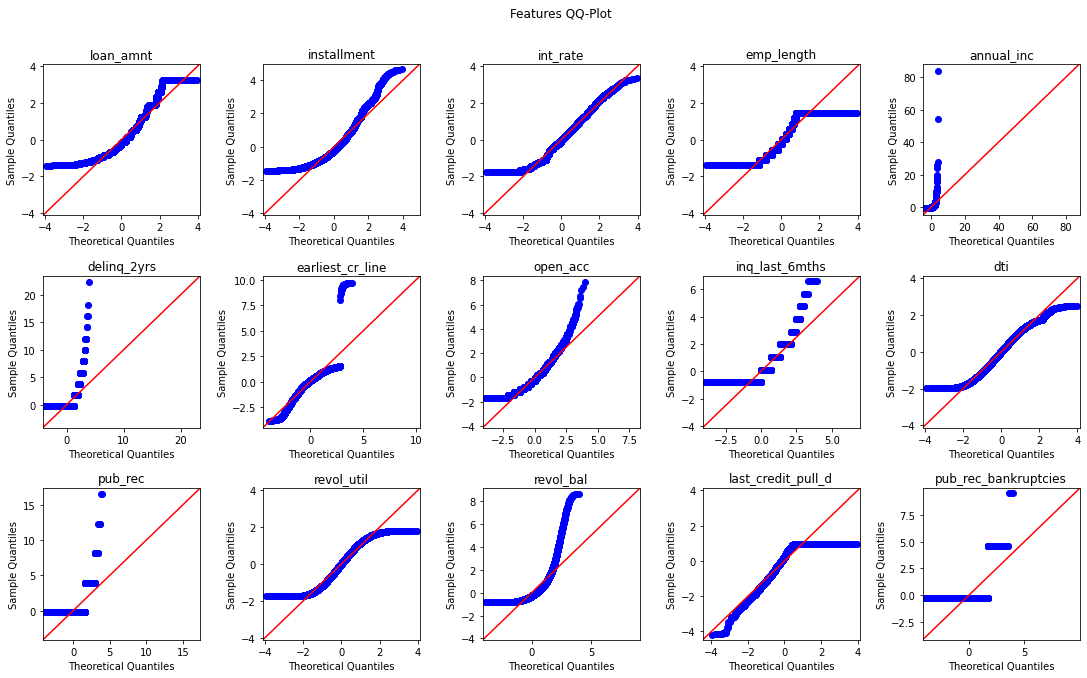

In [42]:
fig, axes = plt.subplots(3, 5, figsize=(18, 10))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
fig.suptitle('Features QQ-Plot')
ax= axes.flatten()
for i in range(0, train_x_numerical.columns.size):
    ax[i].set_title(train_x_numerical.columns[i])
    non_nan_values=train_x_numerical[train_x_numerical.columns[i]].dropna()
    sm.qqplot(non_nan_values, line="45", fit = True, ax=ax[i])


Guardando i QQ-Plots ci rendiamo conto che la maggior parte delle features non hanno distribuzione gaussiana, ma anzi seguono una distibuzione right-skewed (la concavità dei plot è verso l'alto), in particolare ciò è vero per le features che rappresentano processi di conteggio (quelle in cui il plot è a tratti) come: *delinq_2yrs* e *inq_last_6_mths* che contano rispettivamente il numero di insolvenze scadute da più di 30 giorni accadute negli ultimi 2 anni e il numero di richieste negli ultimi 6 mesi.

Per le distribuzioni right-skewed, come la distribuzione di Fisher o la distribuzione di Poisson, esistono delle tecniche apposite per il rilevamento degli outliers che non sono considerate in questa sede.

## Outlier Detection Multivariata: Local Outlier Factor (LOC)

La tecnica impiegata per il rilevamento di outliers multivariato si basa sul Local Outlier Factor.

Il Local Outlier Factor è un valore locale di anomalia di un elemento che dipende da quanto un elemento è isolato rispetto al suo vicinato.
Si considerano per ciascun elemento i k vicini più vicini si calcola la distanza da questi punti; questa distanza viene utilizzata per stimare la densità locale all'elemento. Confrontando la densità locale di un elemento con le densità locali dei suoi vicini, si possono identificare elementi che hanno una densità sostanzialmente inferiore rispetto ai loro vicini. Questi elementi sono considerati outlier.

La LOC è una tecnica non supervisionata per il rilevamento degli outliers quindi non tiene conto del target e in un dataset molto sbilanciato, potrebbe etichettare come possibile outlier un elemento appartenente alla classe meno rappresentata, perché meno densa dell'altra; dunque, prima di eliminare i possibili outliers andiamo ad osservare la proporzione di valori etichettati come possibili outliers dal metodo e verifichiamo che questi appartengano in maniera ugualmente proporzionale alle due classi.

<img src="Immagini\LOF.png" width="400"/>

In [ ]:
clf = LocalOutlierFactor(n_neighbors=20, n_jobs=-1)
outliersMask = clf.fit_predict(X)
outliersX = X.iloc[outliersMask==-1, :]
outliers = pd.concat([outliersX,y], join='inner', axis=1)
outliers.loan_status.value_counts()

I probabili outliers multivariati trovati tramite il LOC sono "solo" 42, cioè $<0.1\%$ dei dati; inotre, questi appartengono per il $28.6\%$ alla classe 1 quindi eliminarli andrebbe, anche se di poco, a sbilanciare ulteriormente il dataset; dunque questi valori vengono mantenuti.

## Scaling

In [41]:
scaler = StandardScaler()
scaled_train_x_num = pd.DataFrame(scaler.fit_transform(train_x_numerical),columns=train_x_numerical.columns, index=train_x_numerical.index)
dataCleaner.set_scaler(scaler)
#TODO controllare se scalare tutte o solo le numeriche

# combino valori numerici con categorici
X = pd.concat([scaled_train_x_num,train_x_categorical],axis=1)
y = train_y.loan_status
print(X.shape, y.shape)
X.head()

(27003, 35) (27003,)


,loan_amnt,installment,int_rate,emp_length,annual_inc,delinq_2yrs,earliest_cr_line,open_acc,inq_last_6mths,dti,...,x2_major_purchase,x2_medical,x2_moving,x2_other,x2_renewable_energy,x2_small_business,x2_vacation,x2_wedding,x3_Source Verified,x3_Verified
29845,-0.279359,-0.149066,-0.453859,-0.544656,-0.200415,-0.296341,0.888178,-1.195736,-0.810570,-0.603072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31699,1.891941,2.324585,-0.453859,1.426868,0.182041,-0.296341,-0.254436,-0.742240,-0.810570,-1.613978,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
30480,-0.822184,-0.709153,0.920243,-0.544656,0.352022,-0.296341,-0.401211,-1.649232,-0.810570,-1.413591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35448,-0.279359,-0.095454,0.254831,-1.389595,-0.029132,-0.296341,0.470148,-0.061996,1.968836,0.383907,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15977,-0.740760,-0.841727,2.010327,-0.544656,-0.285292,-0.296341,0.141670,1.298492,0.115899,0.685983,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Imputazione valori NaN

In [43]:
# elenco numero di valori nan per features
X.isna().sum()

loan_amnt                  0
installment                0
int_rate                   0
emp_length               692
annual_inc                 0
delinq_2yrs                0
earliest_cr_line           0
open_acc                   0
inq_last_6mths             0
dti                        0
pub_rec                    0
revol_util                39
revol_bal                  0
last_credit_pull_d         0
pub_rec_bankruptcies     492
x0_ 60 months              0
x1_NONE                    0
x1_OTHER                   0
x1_OWN                     0
x1_RENT                    0
x2_credit_card             0
x2_debt_consolidation      0
x2_educational             0
x2_home_improvement        0
x2_house                   0
x2_major_purchase          0
x2_medical                 0
x2_moving                  0
x2_other                   0
x2_renewable_energy        0
x2_small_business          0
x2_vacation                0
x2_wedding                 0
x3_Source Verified         0
x3_Verified   

Si effettua imputazione di nan sulle features:

<b>emp_length</b>: la data di occupazione in anni

<b>revol_util</b>: tasso di utilizzo della linea revolving

<b>pub_rec_bankruptcies</b>: Numero di fallimenti di registri pubblici

In [44]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#imp = KNNImputer(n_neighbors=2, weights="uniform")
X[:] = imp.fit_transform(X)
dataCleaner.set_imputer(imp)


In [45]:
X.isna().sum()

loan_amnt                0
installment              0
int_rate                 0
emp_length               0
annual_inc               0
delinq_2yrs              0
earliest_cr_line         0
open_acc                 0
inq_last_6mths           0
dti                      0
pub_rec                  0
revol_util               0
revol_bal                0
last_credit_pull_d       0
pub_rec_bankruptcies     0
x0_ 60 months            0
x1_NONE                  0
x1_OTHER                 0
x1_OWN                   0
x1_RENT                  0
x2_credit_card           0
x2_debt_consolidation    0
x2_educational           0
x2_home_improvement      0
x2_house                 0
x2_major_purchase        0
x2_medical               0
x2_moving                0
x2_other                 0
x2_renewable_energy      0
x2_small_business        0
x2_vacation              0
x2_wedding               0
x3_Source Verified       0
x3_Verified              0
dtype: int64

## Bilanciamento delle classi

<img src="Immagini\riassunto_bilanciamento.png" width="600"/>

### SMOTE

In [ ]:
smote = SVMSMOTE(random_state=0, sampling_strategy='not majority', k_neighbors=3, n_jobs=-1, m_neighbors=10,
                    svm_estimator=svm.SVC(C=0.1, kernel='rbf', gamma=0.01, class_weight=None,
                                        decision_function_shape='ovo'))

#train_x, train_y = smote.fit_resample(X, y)
print(train_x.shape, train_y.shape)
X.head()

(27003, 35) (27003, 1)


,loan_amnt,installment,int_rate,emp_length,annual_inc,delinq_2yrs,earliest_cr_line,open_acc,inq_last_6mths,dti,...,x2_major_purchase,x2_medical,x2_moving,x2_other,x2_renewable_energy,x2_small_business,x2_vacation,x2_wedding,x3_Source Verified,x3_Verified
29845,-0.279359,-0.149066,-0.453859,-0.544656,-0.200415,-0.296341,0.888178,-1.195736,-0.810570,-0.603072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31699,1.891941,2.324585,-0.453859,1.426868,0.182041,-0.296341,-0.254436,-0.742240,-0.810570,-1.613978,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
30480,-0.822184,-0.709153,0.920243,-0.544656,0.352022,-0.296341,-0.401211,-1.649232,-0.810570,-1.413591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35448,-0.279359,-0.095454,0.254831,-1.389595,-0.029132,-0.296341,0.470148,-0.061996,1.968836,0.383907,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15977,-0.740760,-0.841727,2.010327,-0.544656,-0.285292,-0.296341,0.141670,1.298492,0.115899,0.685983,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Oversampling

In [ ]:
oversampling = RandomOverSampler(sampling_strategy = 'not majority', random_state = 0)

#train_x, train_y = oversampling.fit_resample(X, y)
print(train_x.shape, train_y.shape)
X.head()


(27003, 35) (27003, 1)


,loan_amnt,installment,int_rate,emp_length,annual_inc,delinq_2yrs,earliest_cr_line,open_acc,inq_last_6mths,dti,...,x2_major_purchase,x2_medical,x2_moving,x2_other,x2_renewable_energy,x2_small_business,x2_vacation,x2_wedding,x3_Source Verified,x3_Verified
29845,-0.279359,-0.149066,-0.453859,-0.544656,-0.200415,-0.296341,0.888178,-1.195736,-0.810570,-0.603072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31699,1.891941,2.324585,-0.453859,1.426868,0.182041,-0.296341,-0.254436,-0.742240,-0.810570,-1.613978,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
30480,-0.822184,-0.709153,0.920243,-0.544656,0.352022,-0.296341,-0.401211,-1.649232,-0.810570,-1.413591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35448,-0.279359,-0.095454,0.254831,-1.389595,-0.029132,-0.296341,0.470148,-0.061996,1.968836,0.383907,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15977,-0.740760,-0.841727,2.010327,-0.544656,-0.285292,-0.296341,0.141670,1.298492,0.115899,0.685983,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Undersampling

In [46]:
undersampling = RandomUnderSampler(sampling_strategy = 'not majority', random_state = 0)

train_x, train_y = undersampling.fit_resample(X, y)
print(train_x.shape, train_y.shape)
X.head()

(27003, 35) (27003,)


,loan_amnt,installment,int_rate,emp_length,annual_inc,delinq_2yrs,earliest_cr_line,open_acc,inq_last_6mths,dti,...,x2_major_purchase,x2_medical,x2_moving,x2_other,x2_renewable_energy,x2_small_business,x2_vacation,x2_wedding,x3_Source Verified,x3_Verified
29845,-0.279359,-0.149066,-0.453859,-0.544656,-0.200415,-0.296341,0.888178,-1.195736,-0.810570,-0.603072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31699,1.891941,2.324585,-0.453859,1.426868,0.182041,-0.296341,-0.254436,-0.742240,-0.810570,-1.613978,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
30480,-0.822184,-0.709153,0.920243,-0.544656,0.352022,-0.296341,-0.401211,-1.649232,-0.810570,-1.413591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35448,-0.279359,-0.095454,0.254831,-1.389595,-0.029132,-0.296341,0.470148,-0.061996,1.968836,0.383907,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15977,-0.740760,-0.841727,2.010327,-0.544656,-0.285292,-0.296341,0.141670,1.298492,0.115899,0.685983,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 3 Feature selection -----
#### 3.1 PCA
#### 3.2 SelectKBest 


In [47]:
test_x, test_y = dataCleaner.cleanData(raw_test_x, raw_test_y)


/home/valerio/magistrale/ml/MachineLearningProject/dataCleaner.py:42: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  data[feature] = pd.DatetimeIndex(data[feature]).astype(np.int64)*1e-9


### Scelta della metrica 

In [50]:
metric = 'recall'
n_folds = 5
#crossvalidation = KFold(n_splits=10,shuffle=True,random_state=1)

In [90]:
#Plot Feature inportance
#---------------------------------------------------------------------------------------
def plot_feature_importances(model,X_train):
    
    xaxes=list(X_train.columns.values)
    yaxes=list(model.best_estimator_.feature_importances_)
    
    h=dict(zip(xaxes,yaxes))
    s = [(k, h[k]) for k in sorted(h, key=h.get, reverse=False)]
    s=dict(s)
    xaxes=list(s.keys())
    yaxes=list(s.values())
    
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), yaxes, align='center') 
    plt.yticks(np.arange(n_features), xaxes) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [99]:
#Function to plot confusion matrix
#------------------------------------------------------------------------------------------------------------------------------
def plot_conf_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [100]:
def plot_classifier_results(model, test_x, test_y):
    print("Miglior iperparametri: ",model.best_params_)
    print(model.best_score_)
    y_pred = model.predict(test_x)
    #qualita' della predizione rispetto sul test set
    print(classification_report(test_y, y_pred))
    cnf_matrix = confusion_matrix(test_y, y_pred)
    plot_conf_matrix(cnf_matrix, classes=[0,1])



## Naive Bayes

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9935
           1       0.14      1.00      0.25      1639

    accuracy                           0.14     11574
   macro avg       0.07      0.50      0.12     11574
weighted avg       0.02      0.14      0.04     11574



/home/valerio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/valerio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/valerio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


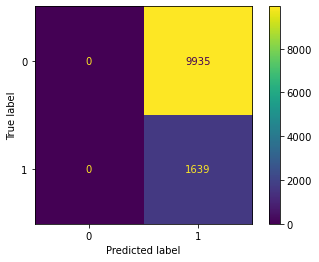

In [103]:
# Naive Bayes
# -------------------------------------------------------------------
nb = GaussianNB()
nb.fit(train_x, train_y)


y_pred = nb.predict(test_x)
#print("Accuracy:",metrics.accuracy_score(test_y, y_pred))
print(classification_report(test_y, y_pred))
plot_confusion_matrix(nb, test_x, test_y)  


## Logistic Regression

In [ ]:
# Logistic Regression
# -------------------------------------------------------------------
myclassifier = LogisticRegression(solver='liblinear')
params = {'penalty':['l1','l2'], 
          'C':[1, 10, 100, 1000]}

gscv_lr = GridSearchCV(myclassifier, param_grid=params, scoring=metric, cv=n_folds, refit=True, n_jobs=-1)

gscv_lr.fit(train_x, train_y)  

Miglior iperparametri:  {'C': 1, 'penalty': 'l1'}
0.031096247519677482
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      9935
           1       0.50      0.00      0.00      1639

    accuracy                           0.86     11574
   macro avg       0.68      0.50      0.46     11574
weighted avg       0.81      0.86      0.79     11574

Confusion matrix, without normalization
[[9934    1]
 [1638    1]]


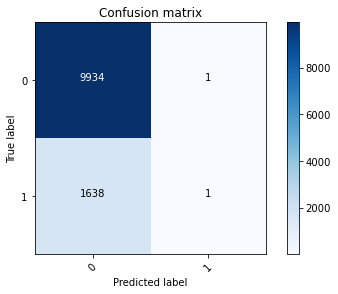

In [101]:
plot_classifier_results(gscv_lr, test_x, test_y)

## Support Vector Machine

In [ ]:
# SVM
# -------------------------------------------------------------------
myclassifier = svm.SVC()
params = {'kernel': ['rbf'], 'gamma':[1e-1, 1e-3, 1e-5], 'C':[1,10,100,1000,10000], 'probability':[True],
            'class_weight':['balanced'], 'tol':[1e-2, 1e-3, 1e-4], 'random_state':[0]}

n_folds = 5
gscv_svm = GridSearchCV(myclassifier, param_grid=params, scoring=metric, cv=n_folds, refit=True, n_jobs=-1)

gscv_svm.fit(train_x, train_y)

In [ ]:
plot_classifier_results(gscv_svm, test_x, test_y)

## Linear Discriminant Analysis (LDA)

In [ ]:
# Linear Discriminant Analysis
# -------------------------------------------------------------------
myclassifier = LinearDiscriminantAnalysis()
params = {'solver': ['svd', 'lsqr', 'eigen']}

gscv_lda = GridSearchCV(myclassifier, param_grid=params, scoring=metric, cv=n_folds, refit=True, n_jobs=-1)

gscv_lda.fit(train_x, train_y)


Miglior iperparametri:  {'solver': 'svd'}
0.04288009861542187
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      9935
           1       0.50      0.00      0.00      1639

    accuracy                           0.86     11574
   macro avg       0.68      0.50      0.46     11574
weighted avg       0.81      0.86      0.79     11574

Confusion matrix, without normalization
[[9934    1]
 [1638    1]]


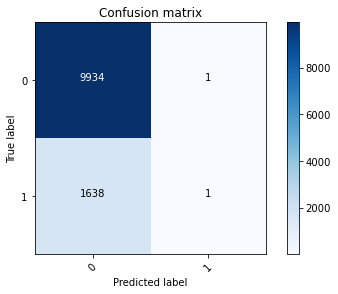

In [84]:
plot_classifier_results(gscv_lda, test_x, test_y)

## Quadratic Discriminant Analysis (QDA)

In [ ]:
# Quadratic Discriminant Analysis
# -------------------------------------------------------------------
# Importante eliminare la correlazione tra le variabili:
#   la multicollinearita' puo' rendere la predizione inaccurata
myclassifier = QuadraticDiscriminantAnalysis()
params = {'reg_param': (0.00001, 0.0001, 0.001,0.01, 0.1), 
            'store_covariance': (True, False),
            'tol': (0.0001, 0.001,0.01, 0.1)}

gscv_qda = GridSearchCV(myclassifier, param_grid=params, scoring=metric, cv=n_folds, refit=True, n_jobs=-1)

gscv_qda.fit(train_x, train_y)

print("Miglior iperparametri: ",gscv_qda.best_params_)
print(gscv_qda.best_score_)

y_pred = gscv_qda.predict(test_x)
#qualita' della predizione rispetto sul test set
print(classification_report(test_y, y_pred))
plot_confusion_matrix(gscv_qda, test_x, test_y)  

In [ ]:
plot_classifier_results(gscv_qda, test_x, test_y)

## Random Forest

In [91]:
# Random Forest
# -------------------------------------------------------------------

myclassifier = RandomForestClassifier(random_state=42)

params = {'criterion' :['gini', 'entropy'],
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8]}

gscv_rf = GridSearchCV(myclassifier, param_grid=params, scoring=metric, cv=n_folds, refit=True, n_jobs=-1)

gscv_rf.fit(train_x, train_y)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             scoring='recall')

Miglior iperparametri:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
0.0012534472945223787
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      9935
           1       0.19      0.01      0.03      1639

    accuracy                           0.85     11574
   macro avg       0.53      0.50      0.47     11574
weighted avg       0.76      0.85      0.79     11574

Confusion matrix, without normalization
[[9838   97]
 [1616   23]]


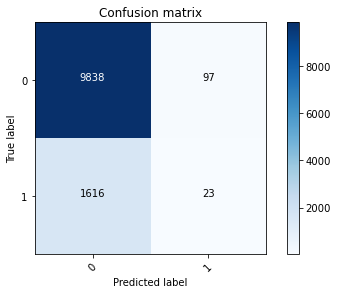

In [94]:
plot_classifier_results(gscv_rf, test_x, test_y)

## Multilayer Perceptron (MLP)

In [ ]:
# Multiple Layer Perceptron
# -------------------------------------------------------------------

myclassifier = MLPClassifier(max_iter=100)

params = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']}

gscv_mlp = GridSearchCV(myclassifier, param_grid=params, scoring=metric, cv=n_folds, refit=True, n_jobs=-1)

gscv_mlp.fit(train_x, train_y)


In [ ]:
plot_classifier_results(gscv_mlp, test_x, test_y)

## K-nearest neighbors

In [ ]:
# KNN
# -------------------------------------------------------------------
myclassifier = KNeighborsClassifier()
params = {'n_neighbors': [3, 5, 7],
         'weights': ['uniform', 'distance'],
         'leaf_size': [15, 30]}
#impossibile parallelizzare knn -> num job = 1
gscv_knn = GridSearchCV(myclassifier, param_grid=params, scoring=metric, cv=n_folds, refit=True, n_jobs=1)

gscv_knn.fit(train_x, train_y)
 

In [ ]:
plot_classifier_results(gscv_knn, test_x, test_y)

## Adaboost

In [ ]:
# Adaboost
# -------------------------------------------------------------------
myclassifier = AdaBoostClassifier()
params = {'n_estimators':[500,1000,2000],
         'learning_rate':[.001,0.01,.1]}

gscv_abc = GridSearchCV(myclassifier, param_grid=params, scoring=metric, cv=n_folds, refit=True, n_jobs=-1)

gscv_abc.fit(train_x, train_y)
  

In [ ]:
plot_classifier_results(gscv_abc, test_x, test_y)

## Comparazione dei modelli

In [ ]:
#tabella

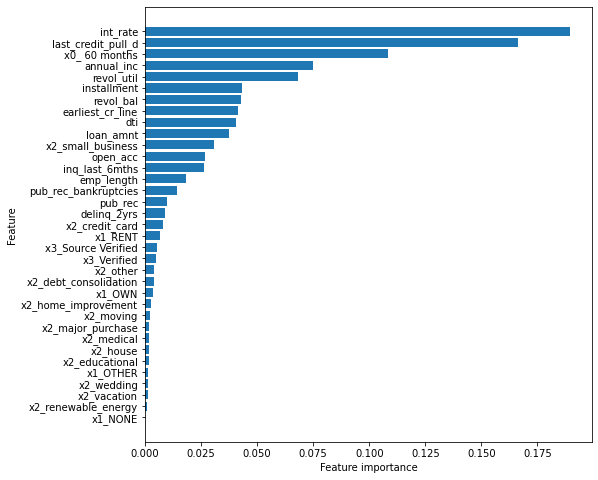

In [95]:
# per uno dei modelli migliori
model = gscv_rf
plot_feature_importances(model,train_x)